# 초기 데이터셋 분석

In [1]:
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.read_csv(Path("/home/hyoon/Documents/ml-powered-application/data/processed/writers/writers.csv"), index_col=0)

# 데이터 포맷

질문의 업보트(upvote) 수,   
답변 수, 답변 받았는지 여부,    
채택된 답변 여부

In [2]:
df.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,ContentLicense,body_text,ParentId,CommunityOwnedDate,OwnerDisplayName
0,1,1,15.0,2010-11-18T20:40:32.857,31,1525.0,<p>I've always wanted to start writing (in a t...,8.0,32946.0,user29032,...,<resources><first-time-author>,10.0,7,20.0,2019-09-09T15:44:30.727,CC BY-SA 3.0,I've always wanted to start writing (in a tota...,NaN,NaN,NaN
1,2,1,16.0,2010-11-18T20:42:31.513,23,10000.0,<p>What kind of story is better suited for eac...,8.0,NaN,user29032,...,<fiction><grammatical-person><third-person>,7.0,0,5.0,NaN,CC BY-SA 3.0,What kind of story is better suited for each p...,NaN,NaN,NaN
2,3,1,31.0,2010-11-18T20:43:28.903,36,799.0,"<p>I finished my novel, and everyone I've talk...",25.0,23159.0,NaN,...,<publishing><novel><agent>,5.0,1,10.0,NaN,CC BY-SA 2.5,"I finished my novel, and everyone I've talked ...",NaN,NaN,NaN
3,5,1,NaN,2010-11-18T20:43:59.693,34,4218.0,<p>I want my short story to have a specific po...,11.0,36826.0,user29032,...,<plot><short-story><planning><brainstorming>,8.0,1,4.0,NaN,CC BY-SA 4.0,I want my short story to have a specific point...,NaN,NaN,NaN
4,7,1,85.0,2010-11-18T20:45:44.067,22,975.0,"<p>I keep hearing about literary fiction, and ...",25.0,25.0,NaN,...,<fiction><genre><categories>,10.0,1,6.0,NaN,CC BY-SA 2.5,"I keep hearing about literary fiction, and how...",NaN,NaN,NaN


In [3]:
# 손쉬운 처리를 위한 데이터 타입 변환

df["AnswerCount"] = df["AnswerCount"].fillna(-1)
df["AnswerCount"] = df["AnswerCount"].astype(int)
df["PostTypeId"] = df["PostTypeId"].astype(int)
df["Id"] = df["Id"].astype(int)
df.set_index("Id", inplace=True, drop=False)

# 포스트 길이 추가
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="") # " " 를 기준으로 title 과 body의 텍스트를 이어 붙임, na 의 경우 공백으로 대체 (한칸 공백, body text가 오게된다.)
df["text_len"] = df["full_text"].str.len()

# 질문의 포스트 타입 == 1
df["is_question"] = df["PostTypeId"] == 1

# 데이터 품질


- 얼마나 많은 텍스트가 누락되어 있는지    
- 텍스트의 품질은 무엇인지    
- 대답이 질문과 일치하는지

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46854 entries, 1 to 59695
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     46854 non-null  int64  
 1   PostTypeId             46854 non-null  int64  
 2   AcceptedAnswerId       5572 non-null   float64
 3   CreationDate           46854 non-null  object 
 4   Score                  46854 non-null  int64  
 5   ViewCount              11079 non-null  float64
 6   Body                   46767 non-null  object 
 7   OwnerUserId            43738 non-null  float64
 8   LastEditorUserId       15939 non-null  float64
 9   LastEditorDisplayName  1018 non-null   object 
 10  LastEditDate           16780 non-null  object 
 11  LastActivityDate       46854 non-null  object 
 12  Title                  11079 non-null  object 
 13  Tags                   11079 non-null  object 
 14  AnswerCount            46854 non-null  int64  
 15  Co

null값을 갖는 Body개수 

In [5]:
sum(df["Body"].isnull())

87

In [6]:
df[df["Body"].isna()]

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,...,FavoriteCount,ClosedDate,ContentLicense,body_text,ParentId,CommunityOwnedDate,OwnerDisplayName,full_text,text_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
2145,2145,5,NaN,2011-03-22T19:49:56.600,0,NaN,NaN,20.0,20.0,NaN,...,NaN,NaN,CC BY-SA 2.5,NaN,NaN,NaN,NaN,,1,False
2147,2147,5,NaN,2011-03-22T19:51:05.897,0,NaN,NaN,20.0,20.0,NaN,...,NaN,NaN,CC BY-SA 2.5,NaN,NaN,NaN,NaN,,1,False
2215,2215,5,NaN,2011-03-24T19:35:10.353,0,NaN,NaN,-1.0,-1.0,NaN,...,NaN,NaN,CC BY-SA 2.5,NaN,NaN,NaN,NaN,,1,False
2218,2218,5,NaN,2011-03-24T19:41:38.677,0,NaN,NaN,-1.0,-1.0,NaN,...,NaN,NaN,CC BY-SA 2.5,NaN,NaN,NaN,NaN,,1,False
2225,2225,5,NaN,2011-03-24T19:58:59.833,0,NaN,NaN,-1.0,-1.0,NaN,...,NaN,NaN,CC BY-SA 2.5,NaN,NaN,NaN,NaN,,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45437,45437,5,NaN,2019-05-26T12:04:39.597,0,NaN,NaN,23253.0,23253.0,NaN,...,NaN,NaN,CC BY-SA 4.0,NaN,NaN,NaN,NaN,,1,False
46197,46197,5,NaN,2019-06-24T15:25:41.197,0,NaN,NaN,32946.0,32946.0,NaN,...,NaN,NaN,CC BY-SA 4.0,NaN,NaN,NaN,NaN,,1,False
50756,50756,5,NaN,2020-04-11T11:59:12.140,0,NaN,NaN,23253.0,23253.0,NaN,...,NaN,NaN,CC BY-SA 4.0,NaN,NaN,NaN,NaN,,1,False


필요한 데이터는 PostTyped == 1 (질문), PostTyped == 2 (답변)이므로 이외의 모든 행 삭제

In [7]:
df = df[df["PostTypeId"].isin([1, 2])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46088 entries, 1 to 59695
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     46088 non-null  int64  
 1   PostTypeId             46088 non-null  int64  
 2   AcceptedAnswerId       5572 non-null   float64
 3   CreationDate           46088 non-null  object 
 4   Score                  46088 non-null  int64  
 5   ViewCount              11079 non-null  float64
 6   Body                   46088 non-null  object 
 7   OwnerUserId            42977 non-null  float64
 8   LastEditorUserId       15180 non-null  float64
 9   LastEditorDisplayName  1010 non-null   object 
 10  LastEditDate           16014 non-null  object 
 11  LastActivityDate       46088 non-null  object 
 12  Title                  11079 non-null  object 
 13  Tags                   11079 non-null  object 
 14  AnswerCount            46088 non-null  int64  
 15  Co

몇가지 질문과 답변 출력, 두 내용 일치, 읽을 수 있는지 판별

In [8]:
question_with_accepted_answers = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())] # 채택된 답변이 있는 질문
q_and_a = question_with_accepted_answers.join(df[["body_text"]], on="AcceptedAnswerId", how="left", rsuffix="_answer")
# df["body_text"] 중 인덱스(Id)가 question_with_accepted_answers dataframe의 "AcceptedAnswerId"값과 일치하는 colum을 추가한다.
# 이때 "body_text" column 이름 오른쪽에 _answer 추가 

pd.options.display.max_colwidth = 500
q_and_a[["body_text", "body_text_answer"]][:3]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."


답변 <= 질문 매칭

In [9]:
df = df.join(df[["Id", "Title", "body_text", "text_len", "Score", "AcceptedAnswerId"]], on="ParentId", how="left", rsuffix="_question")

In [10]:
df[df["Id_question"] == 3].head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,...,OwnerDisplayName,full_text,text_len,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
31,31,2,NaN,2010-11-18T21:08:45.487,13,NaN,"<p>Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.</p>\n\n<p>In the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelo...",35.0,16829.0,NaN,...,NaN,"Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents...",567,False,3.0,How do I find an agent?,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n",114.0,36.0,31.0
228,228,2,NaN,2010-11-19T17:38:50.860,4,NaN,"<p>I seem to recall that either Writers Digest or Writers Market keeps a list you can subscribe to of agents, what genres they work in, query guidelines, etc.</p>\n",111.0,NaN,NaN,...,NaN,"I seem to recall that either Writers Digest or Writers Market keeps a list you can subscribe to of agents, what genres they work in, query guidelines, etc.\n",157,False,3.0,How do I find an agent?,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n",114.0,36.0,31.0
305,305,2,NaN,2010-11-20T19:44:38.233,14,NaN,"<p>I have to add a few things to <a href=""https://writers.stackexchange.com/questions/3/how-do-i-find-an-agent/31#31"">Randomman's answer</a>:</p>\n\n<ul>\n<li>If you have that list, check if the agents are reputable! Google them. There are a lot of black sheep out there.</li>\n<li>Go to the homepage of authors of the same category you write in. Some are mentioning their agents.</li>\n<li>Follow Vatine's advice in his comment to Randomman's answer. If you do not find a guideline, do <strong>n...",99.0,-1.0,NaN,...,NaN,"I have to add a few things to Randomman's answer:\n\nIf you have that list, check if the agents are reputable! Google them. There are a lot of black sheep out there.\nGo to the homepage of authors of the same category you write in. Some are mentioning their agents.\nFollow Vatine's advice in his comment to Randomman's answer. If you do not find a guideline, do not send anything to them without asking. First write an email and ask for permission, if they are interested in your stuff.\nIf the...",743,False,3.0,How do I find an agent?,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n",114.0,36.0,31.0
357,357,2,NaN,2010-11-22T00:30:05.987,9,NaN,"<p>This may not be an exact answer to your question, but:</p>\n\n<p>Don't forget that <strong>you don't always need an agent</strong> (in fact, depending on the agent and your situation, <em>it can be a lot worse than having no agent</em>). </p>\n\n<p>You need to read a bit about <strong>what exactly an agent can do for you</strong> and decide <strong>what kind of agent you want to hire</strong>. </p>\n\n<p>Also be aware that some ""agents"" advertising on line are 100% scam (""hey, I can make ...",67.0,67.0,NaN,...,NaN,"This may not be an exact answer to your question, but:\nDon't forget that you don't always need an agent (in fact, depending on the agent and your sit

최소한 하나의 답변을 받은 질문의 수,    
답변 받지 못한 질문의 수,    
채택된 질문의 수

# 데이터 품질과 분포

- 데이터셋에 얼마나 많은 질문이 있는지    
- 얼마나 많은 질문이 답변을 받았는지    
- 질문은 얼마나 긴지

In [11]:
received_answers = df[df["is_question"] & (df["AnswerCount"] != 0)]
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
len_ = len(df[df["is_question"]])
print(f"총 질문: {len_}, 1개 이상의 답변을 가진 질문: {len(received_answers)}, 답변이 채택된 질문: {len(has_accepted_answer)}")

총 질문: 11079, 1개 이상의 답변을 가진 질문: 10779, 답변이 채택된 질문: 5572


<AxesSubplot:xlabel='Question scores', ylabel='Number of questions'>

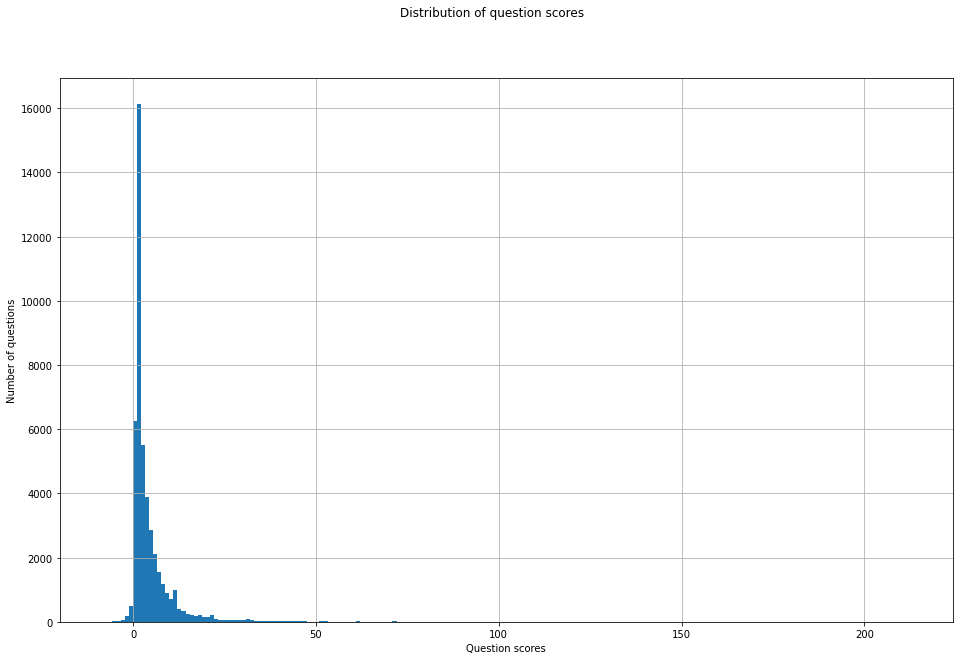

In [12]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Distribution of question scores")
plt.xlabel("Question scores")
plt.ylabel("Number of questions")
df["Score"].hist(bins=200)

데이터셋에 있는 질문의 길이

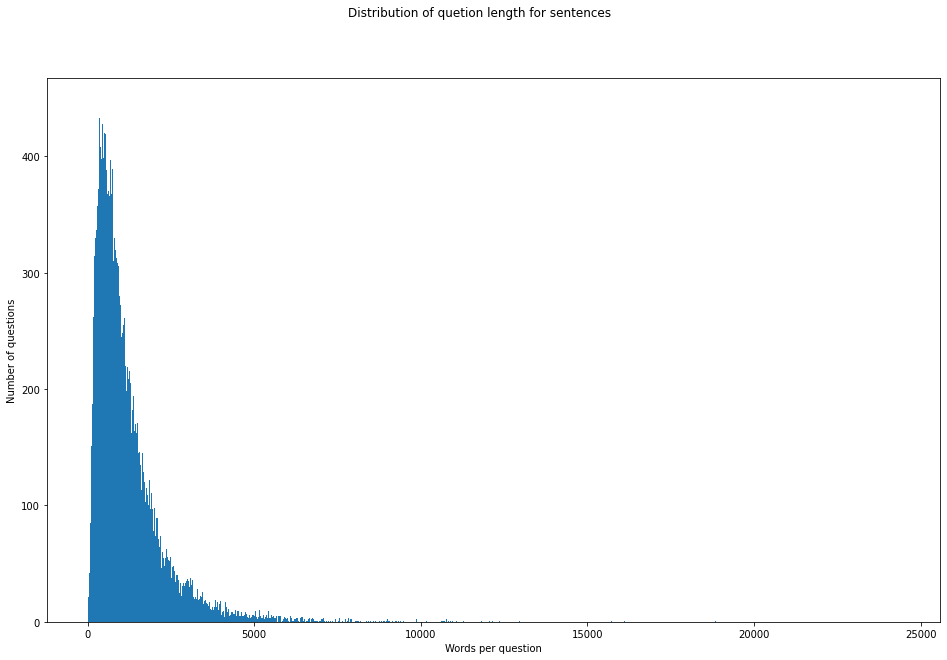

In [13]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of quetion length for sentences")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len = plt.hist(df["text_len"], bins=2000, log=False)

몇 개의 이상치만이 2000개 이상의 단어를 포함하고 있음. => 2000개 이하 부분 확대

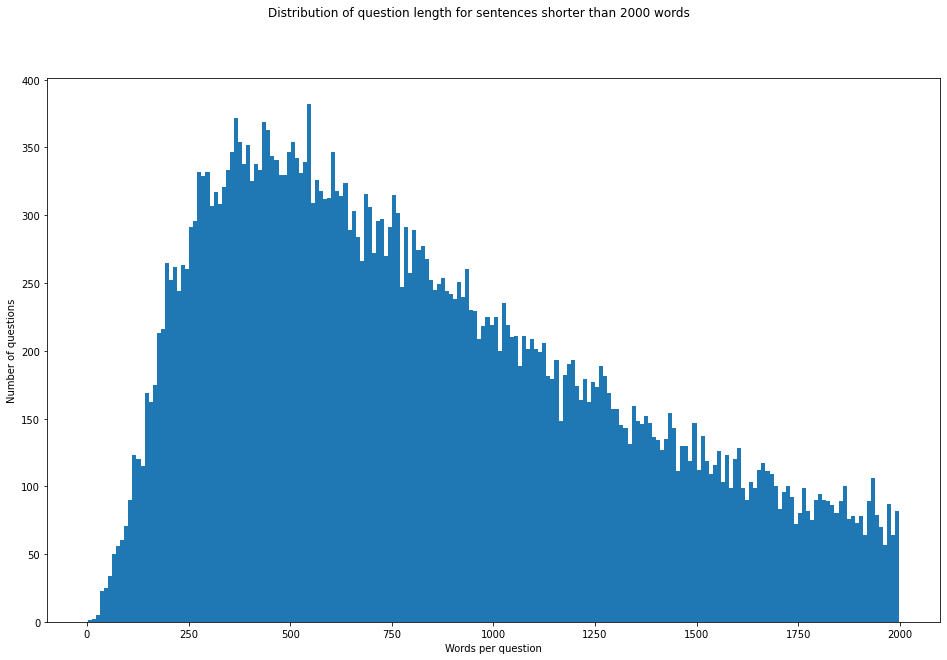

In [14]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle(
    "Distribution of question length for sentences shorter than 2000 words"
)
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len_trunc = plt.hist(df[df["text_len"]<2000]["text_len"], bins=200, log=False)

질문의 길이로 많은 업보트 예측 가능? => 높은 점수 질문과 낮은 점수 질문 분포 그려보기    
중간값(median)기준으로 값 나누기

Text(0, 0.5, 'Percentage of sentence')

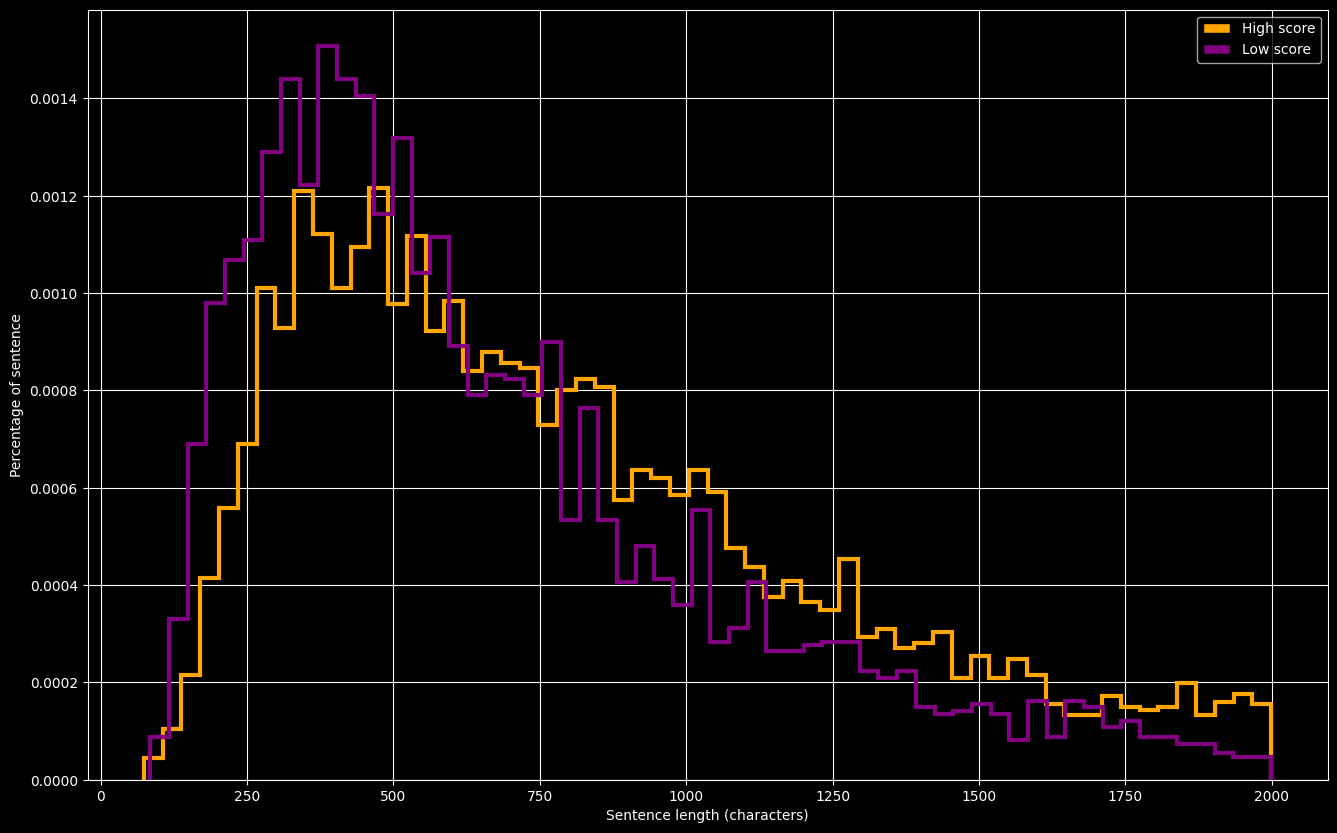

In [26]:
plt.style.use(['dark_background'])
high_score = df["Score"] > df["Score"].median()
# 너무 긴 문장 삭제
normal_length = df["text_len"] < 2000

ax = df[df["is_question"] & high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="orange",
    linewidth=3,
    grid=False,
    figsize=(16,10),
)

df[df["is_question"] * ~high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="purple",
    linewidth=3,
    grid=True
)

handles = [
    Rectangle((0,0), 1, 1, color=c, ec="k") for c in ["orange", "purple"] 
]

labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (characters)")
ax.set_ylabel("Percentage of sentence")

높은 점수의 질문 -> 평균적으로 길이가 더 길다. => 질문의 길이는 모델에 적용할 수 있는 후보 특성.

질문이 받은 답변 수의 분포

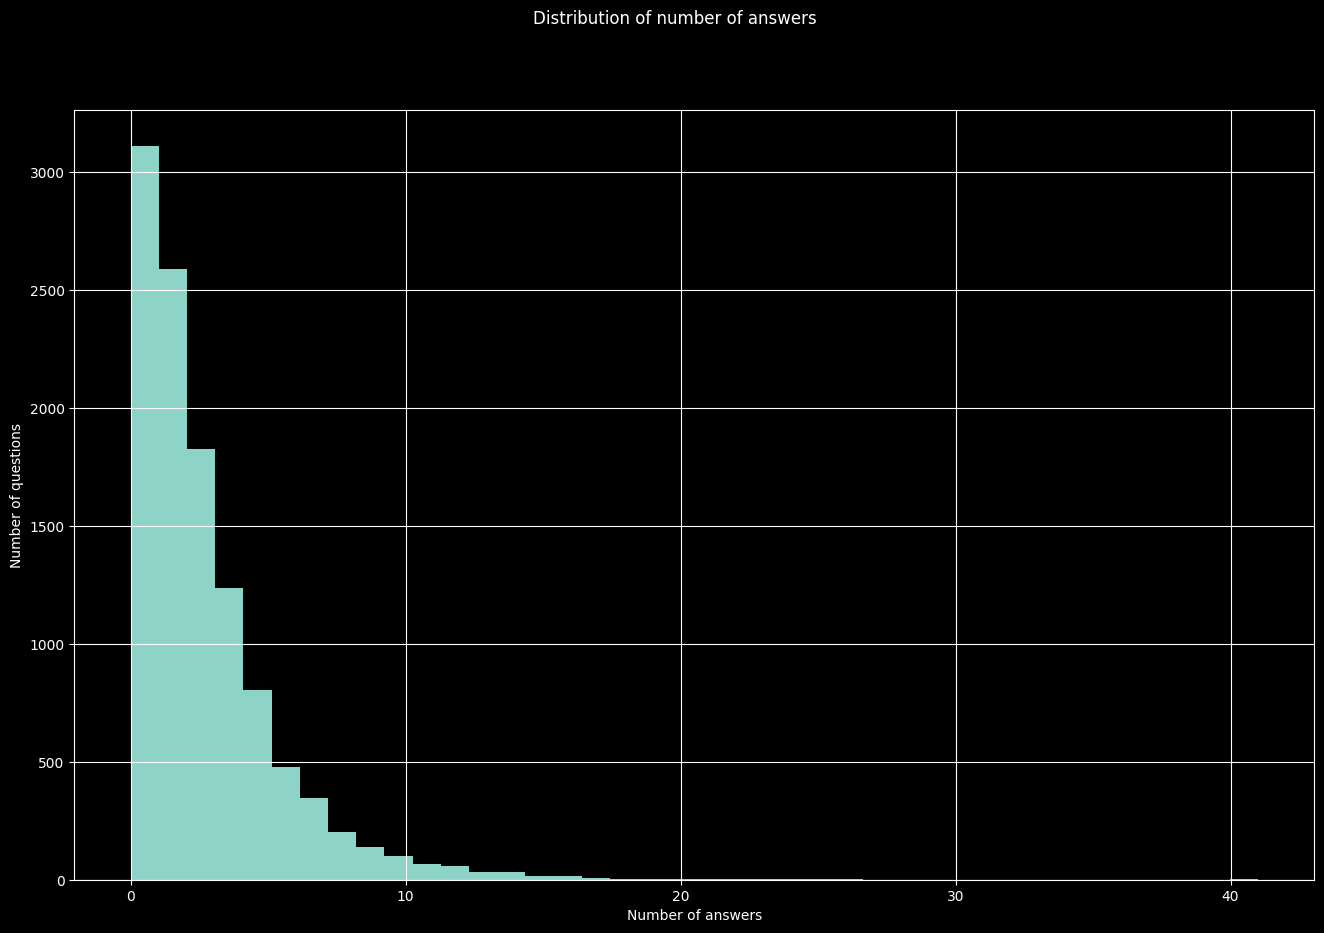

In [27]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Distribution of number of answers")
plt.xlabel("Number of answers")
plt.ylabel("Number of questions")
hist = df[df["is_question"]]["AnswerCount"].hist(bins=40)

높은 점수의 질문이 더 많은 답변을 받았는가?    
=> 우선 한 변수에 대한 함수로 다른 한 변수를 그려 트렌드를 파악해본다.

Text(0.5, 1.0, 'Answer counts as a function of question score')

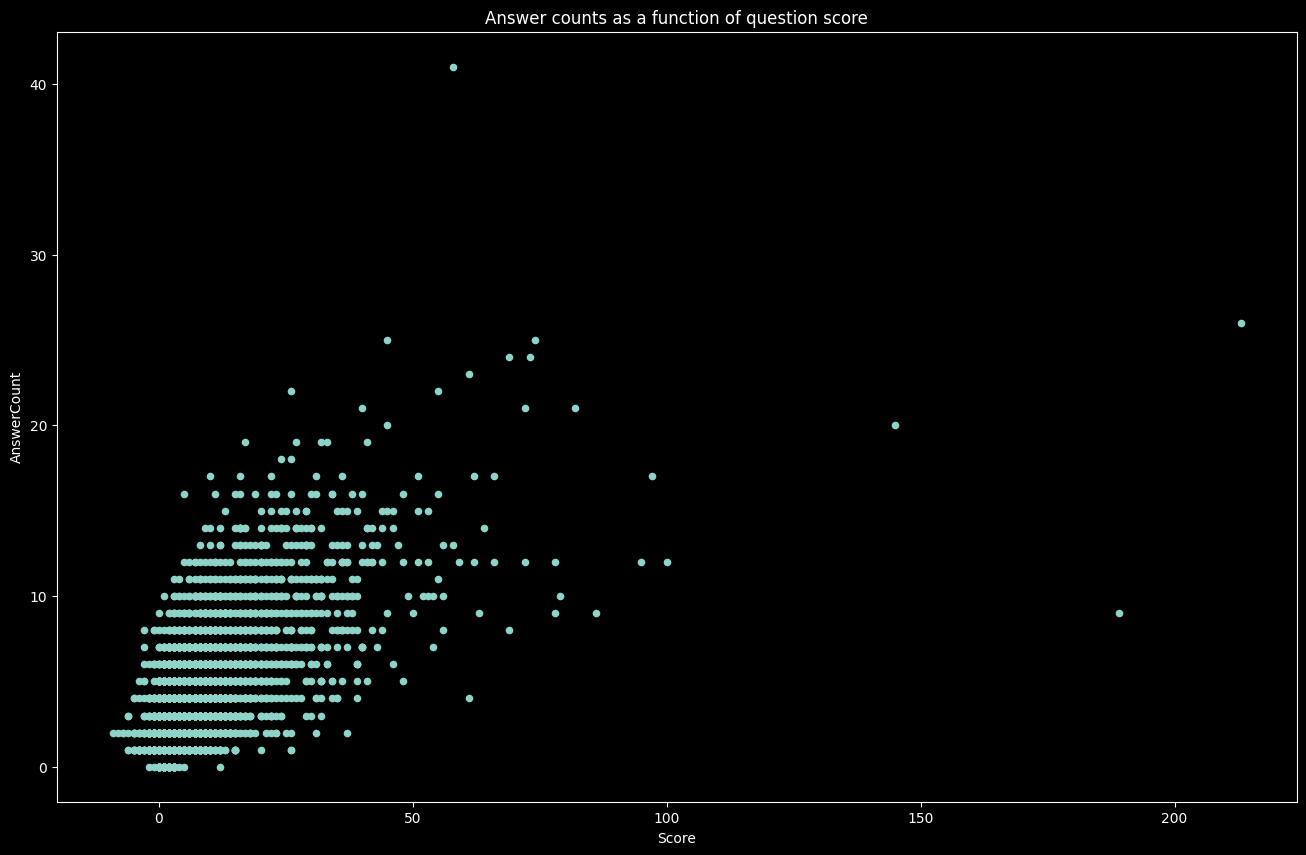

In [28]:
scatter = df[df["is_question"]][["Score", "AnswerCount"]].plot(x="Score", y="AnswerCount", kind="scatter", figsize=(16, 10))
ax.set_xlabel("Score")
ax.set_ylabel("Num_answer")
scatter.set_title("Answer counts as a function of question score")

점수와 답변의 개수 -> 양의 상관관계가 보임.    
높은 점수와 낮은 점수 질문 그룹으로 나눈 후 답변의 개수 체크

Text(0, 0.5, 'Percentage of sentences')

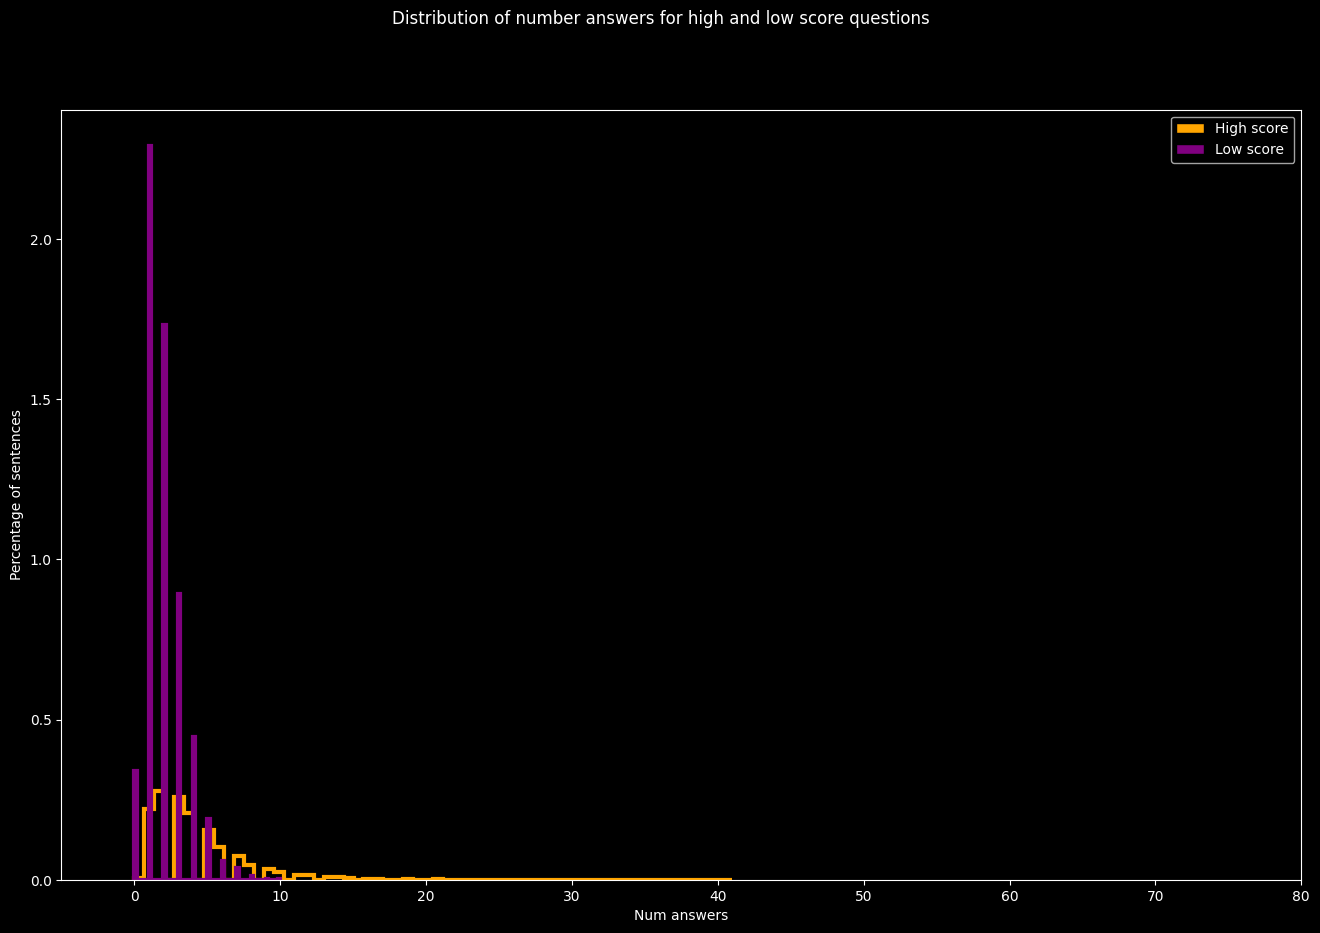

In [35]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Distribution of number answers for high and low score questions")
plt.xlim(-5, 80)

ax = df[df["is_question"] & (df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                                                    density=True,
                                                                                    histtype="step",
                                                                                    color="orange",
                                                                                    linewidth=3,
                                                                                    grid=False,
                                                                                    figsize=(16, 10))

df[df["is_question"] & ~(df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                                                density=True,
                                                                                histtype="step",
                                                                                color="purple",
                                                                                linewidth=3,
                                                                                grid=False
                                                                                )

handles = [Rectangle((0, 0), 1, 1, color=c, ec='k') for c in ["orange", "purple"]]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Num answers")
ax.set_ylabel("Percentage of sentences")


높은 점수를 얻은 질문이 더 많은 답변을 얻은 것을 확인할 수 있음.    
하지만 답변의 개수는 사용자가 질문을 입력하는 추론시에 얻을 수 없는 데이터이므로 훈련 특성으로 사용할 수 없다.    
모델이 답변의 개수 없이 동작을 해야하므로   
1. 훈련 때부터 무시.
2. 훈련시에 특성으로 사용하고 추론시에 특정 상수로 사용.
방법이 존재.
첫번째 방법이 간단하나 다른 스타일의 영향에서 답변 개수 특성의 영향을 분리하는데 도움이 된다.(??)